# Shark alley bathymetric survey 20/11/2024

Make a 3D plot from single beam echo sounder data!

### Import neccessary libraries

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import medfilt
import numpy.ma as ma


#### Read and check the data:

In [10]:
data = pd.read_csv('data/241119_shark_alley_survey.csv')
data.head() # This allows us to look at the top of the dataframe. 

,Pt_name,East,North,Elevation,Depth,Code
0,bathy_tfcf,407021.807,7400265.780,-3.569,-1.80,
1,bathy_tfcg,407020.805,7400266.208,-3.536,-1.68,
2,bathy_tfch,407019.667,7400266.374,-3.610,-1.64,
3,bathy_tfci,407018.563,7400266.591,-3.643,-1.68,
4,bathy_tfcj,407017.314,7400266.695,-3.673,-1.64,


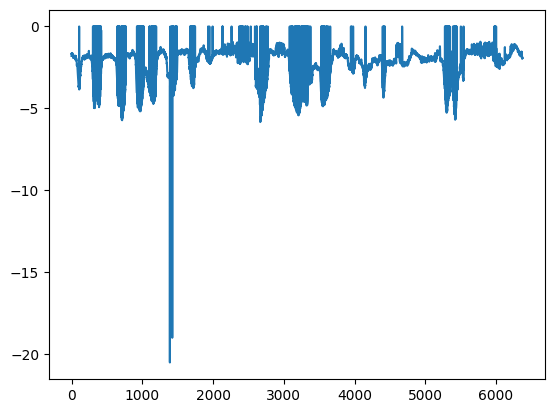

In [11]:
plt.plot(data['Depth'])

#### The data is messy!

There are some zero values and some very deep measurements that seem unrealistic. 

The code below will clean the data.

<Axes: >

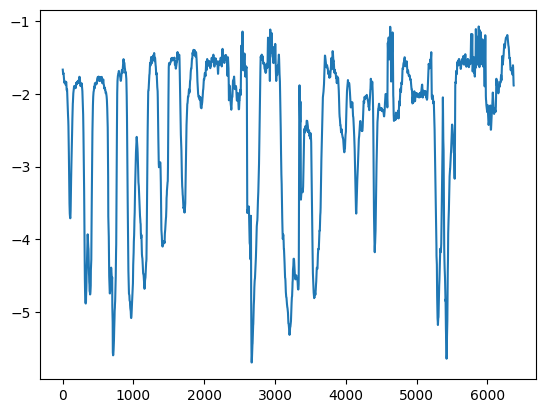

In [12]:
# Step 1: Remove zeros
data = data[data['Depth'] <= -1].copy()

# Step 2: Apply median filter to remove spikes
window_size = 7  # Choose an odd number for the window size (e.g., 3, 5, 7)

# Step 3: Apply rolling average to smooth the data further
rolling_window = 5  # Choose the rolling window size

data['depth_despiked'] = medfilt(data['Depth'], kernel_size=window_size)
data['depth_smoothed'] = data['depth_despiked'].rolling(window=rolling_window, center=True).mean()
data['depth_smoothed'].plot()



Much better! 

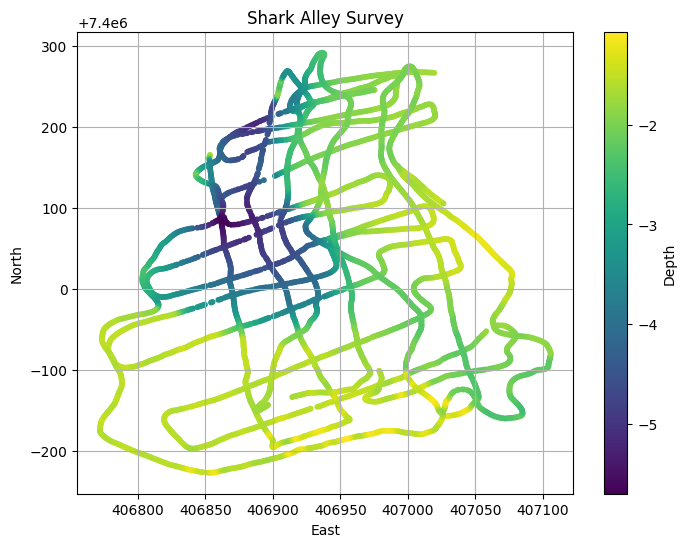

In [13]:

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data['East'], data['North'], c=data['depth_smoothed'], cmap='viridis', s=10)
plt.colorbar(scatter, label='Depth')
plt.xlabel('East')
plt.ylabel('North')
plt.title('Shark Alley Survey')
plt.grid(True)

plt.show()

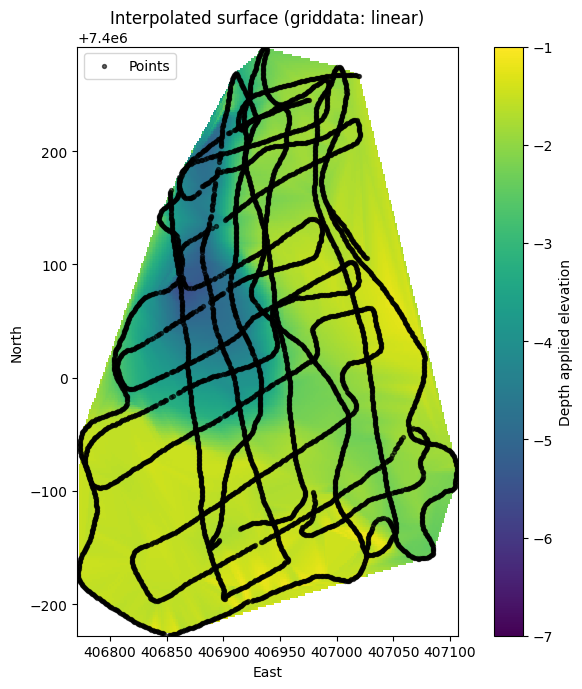

/tmp/ipykernel_2223/1219924147.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=True)


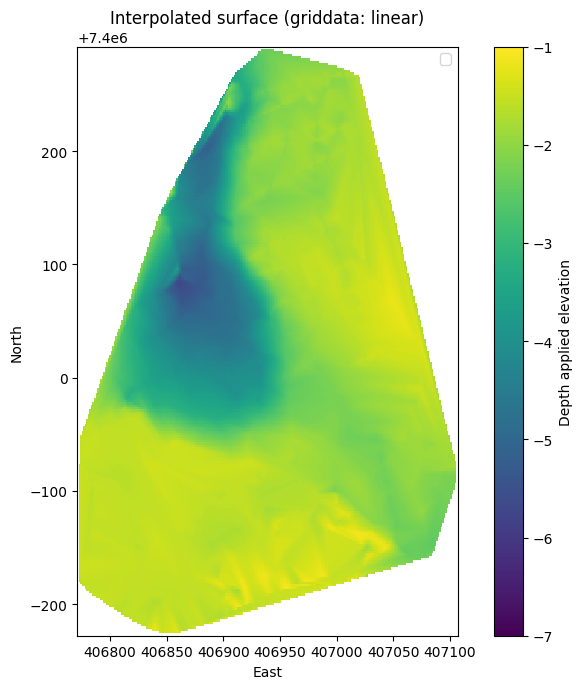

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# --- Input: merged_data with columns 'East', 'North', 'Depth applied elevation'
df = data[['East', 'North', 'depth_smoothed']].dropna().copy()

# If duplicate xy points exist, average their z to avoid issues
df = df.groupby(['East', 'North'], as_index=False)['depth_smoothed'].mean()

# Coords and values
xy = df[['East', 'North']].to_numpy()
z  = df['depth_smoothed'].to_numpy()

# --- Make a grid (adjust nx, ny for resolution)
nx, ny = 250, 250
xmin, xmax = xy[:,0].min(), xy[:,0].max()
ymin, ymax = xy[:,1].min(), xy[:,1].max()

gx = np.linspace(xmin, xmax, nx)
gy = np.linspace(ymin, ymax, ny)
GX, GY = np.meshgrid(gx, gy)

# --- Interpolate (method='linear' | 'cubic' | 'nearest')
Z = griddata(points=xy, values=z, xi=(GX, GY), method='linear')

# --- Plot
plt.figure(figsize=(7.5, 7))
im = plt.pcolormesh(GX, GY, Z, shading='auto', vmin=-7, vmax=-1)
plt.scatter(xy[:,0], xy[:,1], s=8, c='k', alpha=0.6, label='Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('East'); plt.ylabel('North')
cbar = plt.colorbar(im); cbar.set_label('Depth applied elevation')
plt.title('Interpolated surface (griddata: linear)')
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

# --- Plot
plt.figure(figsize=(7.5, 7))
im = plt.pcolormesh(GX, GY, Z, shading='auto', vmin=-7, vmax=-1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('East'); plt.ylabel('North')
cbar = plt.colorbar(im); cbar.set_label('Depth applied elevation')
plt.title('Interpolated surface (griddata: linear)')
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


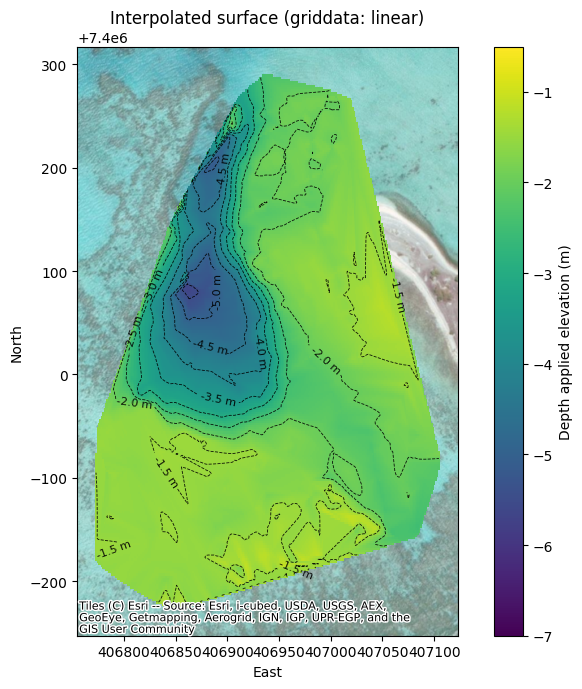

In [18]:
import numpy as np

import contextily as ctx

# --- CRS (update to match your data) -----------------------------------------
crs_code = "EPSG:32756"  # e.g., UTM 56S

# --- Plot coloured mesh ------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.5, 7))

Zmask = ma.masked_invalid(Z)  # safer contours if any NaNs in Z

im = ax.pcolormesh(
    GX, GY, Zmask,
    shading='auto',
    vmin=-7, vmax=-0.5,
    rasterized=True,
    cmap='viridis'
)

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('East'); ax.set_ylabel('North')
ax.set_title('Interpolated surface (griddata: linear)')

# --- Colourbar ---------------------------------------------------------------
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Depth applied elevation (m)')

# --- Bounds + a small zoom-out ----------------------------------------------
x0, x1 = np.nanmin(GX), np.nanmax(GX)
y0, y1 = np.nanmin(GY), np.nanmax(GY)
pad = 0.05
dx, dy = (x1 - x0) * pad, (y1 - y0) * pad
ax.set_xlim(x0 - dx, x1 + dx)
ax.set_ylim(y0 - dy, y1 + dy)

# --- Basemap (imagery) -------------------------------------------------------
ctx.add_basemap(
    ax,
    crs=crs_code,
    source=ctx.providers.Esri.WorldImagery,
    alpha=0.9
)

# Re-assert limits if contextily nudged them
ax.set_xlim(x0 - dx, x1 + dx)
ax.set_ylim(y0 - dy, y1 + dy)

# --- Isobaths (contours) -----------------------------------------------------
# Choose a contour interval that suits your data range
# e.g., every 0.5 m from -7 to -0.5 m
levels = np.arange(-7.0, -0.5 + 1e-9, 0.5)

cs = ax.contour(
    GX, GY, Zmask,
    levels=levels,
    colors='k',          # simple, high-contrast lines
    linewidths=0.6,
    alpha=0.9
)

# Optional: label contours (inline) in metres
ax.clabel(cs, fmt=lambda v: f"{v:.1f} m", inline=True, fontsize=8, inline_spacing=2)

# If you want thicker index contours every 1 m, uncomment:
# cs_bold = ax.contour(GX, GY, Zmask, levels=np.arange(-7, -0.5 + 1e-9, 1.0),
#                      colors='k', linewidths=1.0, alpha=0.9)

ax.margins(0)
plt.tight_layout()
plt.show()


Don't use this map for navigation